TODO List:
- normalize all samples to use coordinates relative to an origin at the centroid of the 3 participating hotspots for that sample

In [36]:
import numpy as np
import random
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
from typing import List, Tuple
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_8707/566273763.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [37]:
data = pd.read_csv("data/mappers.csv")
data = data.drop(["id"], axis=1)

In [38]:
data.shape

(7276109, 16)

In [39]:
data.head()

,latitude,longitude,frequency,spreading_factor,hotspot1_lat,hotspot1_long,hotspot1_rssi,hotspot1_snr,hotspot2_lat,hotspot2_long,hotspot2_rssi,hotspot2_snr,hotspot3_lat,hotspot3_long,hotspot3_rssi,hotspot3_snr
0,44.305403,-96.806407,904.099976,SF7BW125,44.304234,-96.780698,-117.0,-2.8,44.320588,-96.912926,-117.0,-5.2,44.293880,-96.812899,-118.0,-4.000000
1,50.720951,-1.876882,868.299988,SF10BW125,50.715620,-1.883604,-112.0,-12.0,50.725903,-1.865836,-117.0,-11.8,50.721518,-1.874929,-120.0,-16.200001
2,36.144499,-86.792449,904.299988,SF9BW125,36.152221,-86.791273,-85.0,7.2,36.196064,-86.850049,-102.0,2.5,36.150951,-86.792024,-102.0,-0.200000
3,33.228809,-117.011214,904.299988,SF7BW125,33.302632,-116.852721,-100.0,4.8,33.252398,-117.004042,-103.0,4.8,33.094660,-116.581460,-122.0,-9.200000
4,36.146766,-86.795201,904.299988,SF9BW125,36.196064,-86.850049,-106.0,0.2,36.152345,-86.790965,-111.0,-4.8,36.143980,-86.789434,-112.0,1.200000


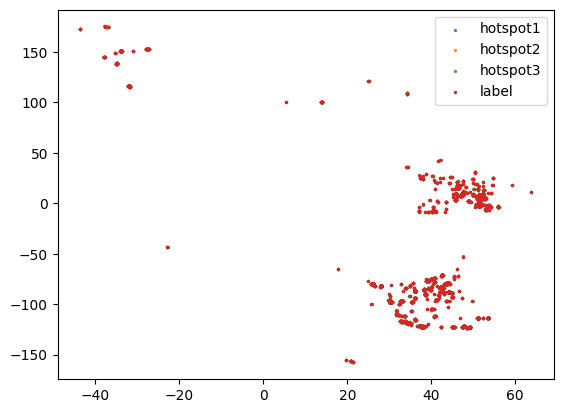

In [40]:
# Visualize some samples
subset = data.sample(n=2500)
for i in range(1,4):
    plt.scatter(subset[f"hotspot{i}_lat"], subset[f"hotspot{i}_long"], s=2, alpha=0.8, label=f"hotspot{i}")
plt.scatter(subset["latitude"], subset["longitude"], s=2, label="label")
plt.legend()

In [41]:
# Convert categorical spreading factors to one-hot
sf_original = data.pop("spreading_factor")
data = pd.concat([data, sf_original.str.get_dummies()], axis=1)
data.head()

,latitude,longitude,frequency,hotspot1_lat,hotspot1_long,hotspot1_rssi,hotspot1_snr,hotspot2_lat,hotspot2_long,hotspot2_rssi,...,hotspot3_rssi,hotspot3_snr,SF10BW125,SF11BW125,SF12BW125,SF7BW125,SF7BW250,SF8BW125,SF8BW500,SF9BW125
0,44.305403,-96.806407,904.099976,44.304234,-96.780698,-117.0,-2.8,44.320588,-96.912926,-117.0,...,-118.0,-4.000000,0,0,0,1,0,0,0,0
1,50.720951,-1.876882,868.299988,50.715620,-1.883604,-112.0,-12.0,50.725903,-1.865836,-117.0,...,-120.0,-16.200001,1,0,0,0,0,0,0,0
2,36.144499,-86.792449,904.299988,36.152221,-86.791273,-85.0,7.2,36.196064,-86.850049,-102.0,...,-102.0,-0.200000,0,0,0,0,0,0,0,1
3,33.228809,-117.011214,904.299988,33.302632,-116.852721,-100.0,4.8,33.252398,-117.004042,-103.0,...,-122.0,-9.200000,0,0,0,1,0,0,0,0
4,36.146766,-86.795201,904.299988,36.196064,-86.850049,-106.0,0.2,36.152345,-86.790965,-111.0,...,-112.0,1.200000,0,0,0,0,0,0,0,1


In [42]:
# Normalize lat/long labels to range -1:1
data["latitude"] = 1 - 2* (data["latitude"] + 90.0) / 180.0
data["longitude"] = 1 - 2* (data["longitude"] + 180.0) / 360.0

In [43]:
# Split the data into train and test with 80 train / 20 test
data_train, data_val = train_test_split(data, test_size=0.2, random_state = 1)

In [44]:
# Extract the labels (latitude and longitude)
y_train = data_train[['latitude', 'longitude']].to_numpy()
y_val = data_val[['latitude', 'longitude']].to_numpy()
print(y_train.shape, y_train.min(), y_train.max())
print(y_val.shape, y_val.min(), y_val.max())

(5820887, 2) -0.9758313863472121 0.8860121607476376
(1455222, 2) -0.9757086593417743 0.8860623349414842


In [45]:
# Extract the samples (data features, without labels)
x_train = np.array(data_train.drop(["latitude", "longitude"], axis=1))
x_val = np.array(data_val.drop(["latitude", "longitude"], axis=1))

# Normalize all features to expected range -1:1 based on consideration of the training data alone
X_TRAIN_MIN = x_train.min(axis=0)
X_TRAIN_RANGE = x_train.ptp(axis=0)

x_train = 1 - 2 * (x_train - X_TRAIN_MIN) / X_TRAIN_RANGE
x_val = 1 - 2 * (x_val - X_TRAIN_MIN) / X_TRAIN_RANGE

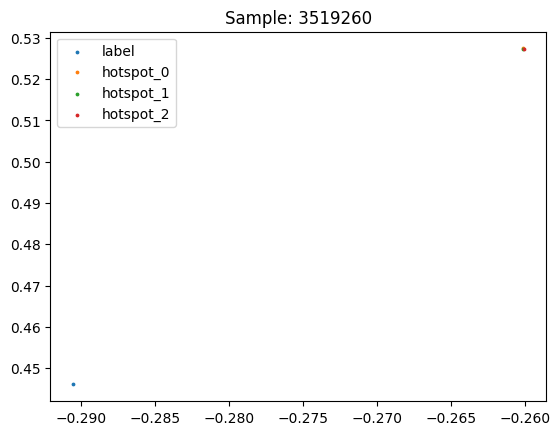

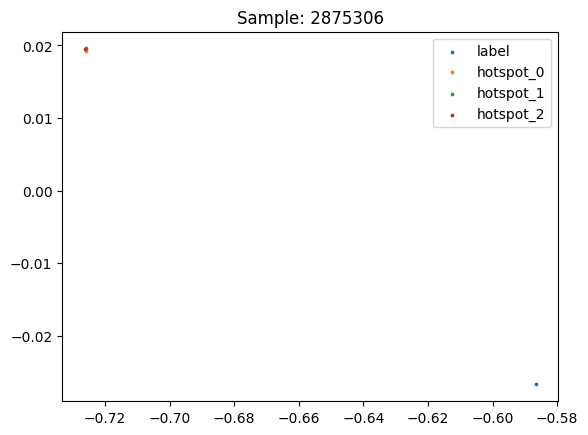

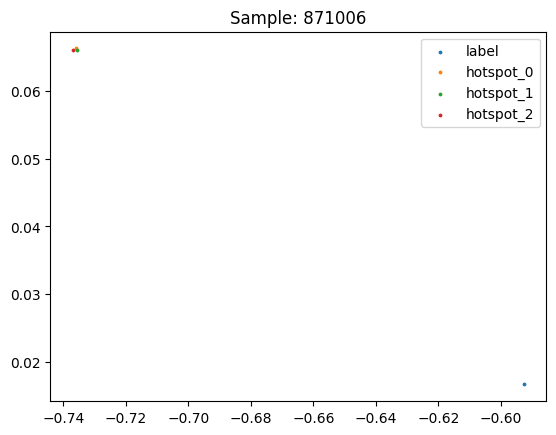

In [46]:
# Visualize a few samples and labels
for _ in range(3):
    sample_idx = np.random.randint(0, y_train.shape[0])
    plt.figure()
    plt.scatter(y_train[sample_idx,0], y_train[sample_idx,1], s=3, label="label")
    for hs_idx, (x_idx, y_idx) in enumerate([(1,2), (5,6), (9,10)]):
        plt.scatter(x_train[sample_idx,x_idx], x_train[sample_idx,y_idx], s=3, label=f"hotspot_{hs_idx}")
    plt.legend()
    plt.title(f"Sample: {sample_idx}")

In [47]:
RANDOM_SEED = 42
N_DIMENSIONS = y_train.shape[-1]
N_CHANNELS = x_train.shape[-1]

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [49]:
torch.manual_seed(RANDOM_SEED)

Xtr, Ytr = torch.tensor(x_train).float().to(device), torch.tensor(y_train).float().to(device)
Xval, Yval = torch.tensor(x_val).float().to(device), torch.tensor(y_val).float().to(device)

def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    src_data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, src_data.shape[0], (batch_size,))
    return src_data[ix], labels[ix]

In [50]:
class MlpTriangulationModel(nn.Module):
    def __init__(
        self, hidden_layer_size: int = 64, n_hidden_layers: int = 5, b_norm: bool = True
    ):
        super().__init__()
        fan_in_out = [
            (N_CHANNELS, hidden_layer_size)
        ] + (n_hidden_layers - 1) * [(hidden_layer_size, hidden_layer_size)]
        layers = [
            # Flatten the data for each node into a single vector like so: [x1,y1,ss1, x2,y2,ss2...]
            nn.Flatten(start_dim=1)
        ]
        for fan_in, fan_out in fan_in_out:
            layers += (
                [nn.Linear(fan_in, fan_out, bias=not b_norm)]
                + ([nn.BatchNorm1d(fan_out)] if b_norm else [])
                + [nn.ReLU()]
            )

        layers.append(nn.Linear(fan_in_out[-1][-1], N_DIMENSIONS))
        # parameter init
        with torch.no_grad():
            layers[-1].weight *= 0.1  # make last layer less confident
        self.layers = nn.Sequential(*layers)

    def forward(self, samples: Tensor, targets: Tensor = None) -> Tuple[Tensor, Tensor]:
        logits = self.layers(samples)
        if targets is None:
            loss = None
        else:
            loss = F.mse_loss(logits, targets)
            # loss = F.l1_loss(logits, targets)
        return logits, loss


In [51]:
# Create model
model = MlpTriangulationModel()
# model = TransformerTriangulationModel()
# model = ImageTriangulationModel()

model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

0.018498 M parameters


In [52]:
# Training
BATCH_SIZE = 128
MAX_STEPS = 25000
LR_DECAY = [MAX_STEPS//3, 4*MAX_STEPS//5]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

def evaluate(data:Tensor, labels:Tensor)->Tuple[float, float]:
    with torch.no_grad():
        predictions, _ = model(data)
    euclidean_err = np.linalg.norm(predictions.cpu().numpy() - labels.cpu().numpy(), axis=1)
    return euclidean_err.mean(), euclidean_err.std()


model.train()
for i in range(MAX_STEPS):
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    logits, loss = model(Xb,Yb)
    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
    step_stats = {
        "step": i,
        "loss": loss.item()
    }
    if i % PRINT_INTERVAL == 0:
        with torch.no_grad():
            val_error_mean, val_error_std = evaluate(data=Xval, labels=Yval)
            step_stats["val_error_mean"] = val_error_mean
            step_stats["val_error_std"] = val_error_std
        print(f"Step: {i},\t Loss: {loss.item():.6f},\tValErr: {val_error_mean:.4f} (std:: {val_error_std:.4f})")
    stats.append(step_stats)

Step: 0,	 Loss: 0.246856,	ValErr: 0.4389 (std:: 0.2676)
Step: 1000,	 Loss: 0.000620,	ValErr: 0.0294 (std:: 0.0163)
Step: 2000,	 Loss: 0.000388,	ValErr: 0.0202 (std:: 0.0251)
Step: 3000,	 Loss: 0.000221,	ValErr: 0.0181 (std:: 0.0087)
Step: 4000,	 Loss: 0.000224,	ValErr: 0.0140 (std:: 0.0100)
Step: 5000,	 Loss: 0.000268,	ValErr: 0.0094 (std:: 0.0073)
Step: 6000,	 Loss: 0.000201,	ValErr: 0.0113 (std:: 0.0064)
Step: 7000,	 Loss: 0.000141,	ValErr: 0.0103 (std:: 0.0057)
Step: 8000,	 Loss: 0.000134,	ValErr: 0.0080 (std:: 0.0080)
Adjusting LR
Step: 9000,	 Loss: 0.000047,	ValErr: 0.0033 (std:: 0.0026)
Step: 10000,	 Loss: 0.000049,	ValErr: 0.0041 (std:: 0.0028)
Step: 11000,	 Loss: 0.000023,	ValErr: 0.0045 (std:: 0.0033)
Step: 12000,	 Loss: 0.000050,	ValErr: 0.0041 (std:: 0.0037)
Step: 13000,	 Loss: 0.000039,	ValErr: 0.0054 (std:: 0.0043)
Step: 14000,	 Loss: 0.000015,	ValErr: 0.0060 (std:: 0.0030)
Step: 15000,	 Loss: 0.000037,	ValErr: 0.0037 (std:: 0.0042)
Step: 16000,	 Loss: 0.000026,	ValErr: 0.

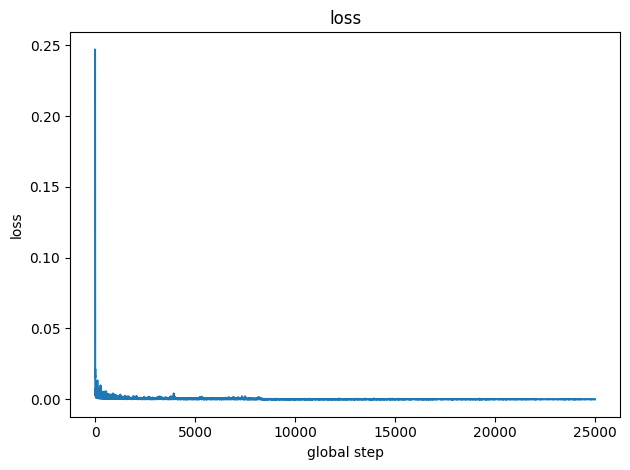

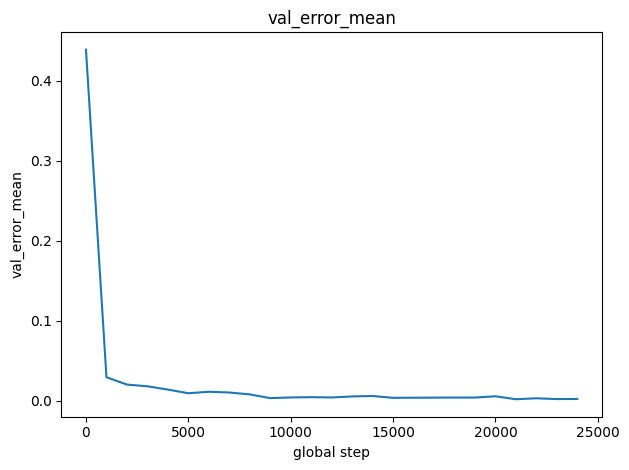

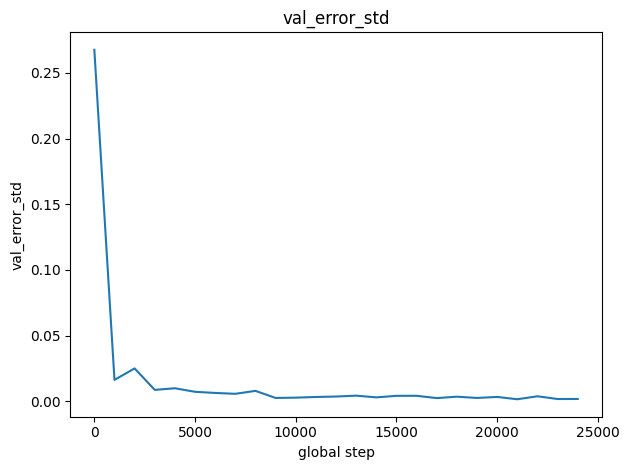

In [53]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.pop("step", i)
    for k, v in step_stats.items():
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    plt.figure()
    plt.title(k)
    plt.plot(x, y)
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()


Visualize some samples below... 
- not sure why most samples seem to be comprised of a cluster of hotspots and a label FAR away (relative to how close the hotspots are clustered). It seems like it would be easier to triangulate using hotspots that surround the target location... if available

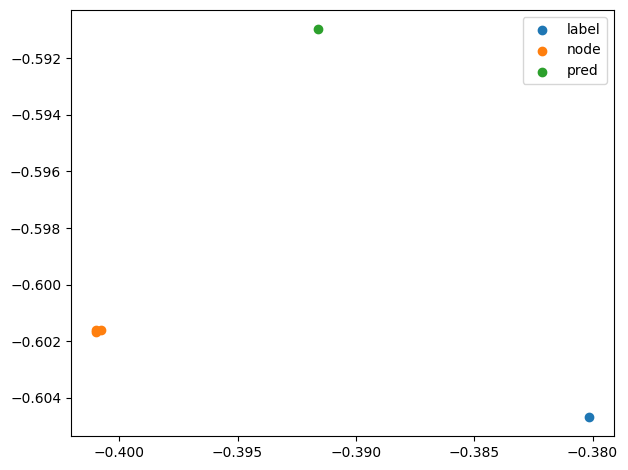

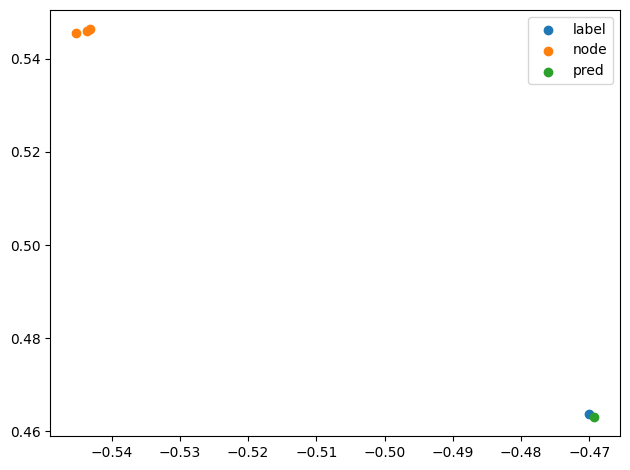

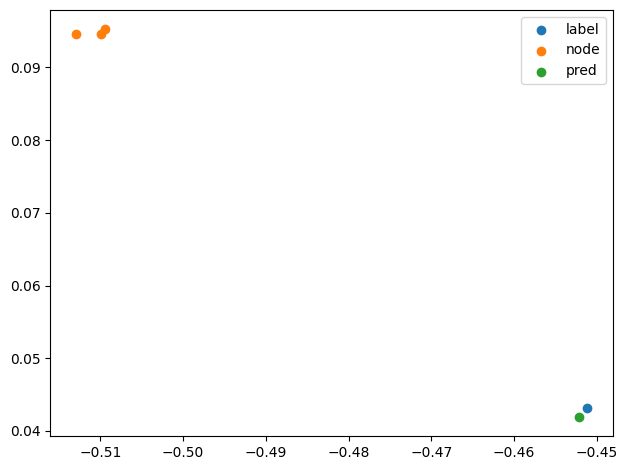

In [54]:
# Predict
samples, labels = get_batch(batch_size=3, is_train=False)
model.eval()
predictions, _ = model(samples)
for sample, label, pred in zip(samples.cpu(), labels.cpu(), predictions.cpu()):
    nodes_x = [x for i, x in enumerate(sample) if i in (1,5,9)]
    nodes_y = [x for i, x in enumerate(sample) if i in (2,6,10)]
    plt.figure()
    plt.scatter(x=label[0], y=label[1], label="label")
    plt.scatter(
        x=nodes_x,
        y=nodes_y,
        label="node",
    )
    plt.scatter(x=pred[0].item(), y=pred[1].item(), label="pred")
    plt.tight_layout()
    plt.legend()